# Theory Calculation of Carbon Footprint

$$C_I = \eta^{-1} \left[ \frac{\langle r_{\leq \zeta l} \rangle}{\langle r \rangle} \, F_r(\zeta \ell) + 2\,\beta \frac{\ell}{\langle r \rangle} \, \bar F_r(\zeta \ell)\right] + 4 Q \varepsilon_0 \frac{\langle r \rangle}{\ell}\,,$$

## Imports, Constants, and Symbols

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import sympy
from IPython.display import display, Markdown
from ipywidgets import interact, interactive, FloatSlider

In [2]:
eps0 = 800/130
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))
zeta = 2*beta

E = 8000 # per <r>^2
mean_distance = 1
mu = 10 # per day
nu = 1 # per day
Q = mu/(nu*E*mean_distance**2) # = M/R

A = mean_distance*2 # Upper constant for uniform Distr.
M = 1000
ell_min = 0.1
ell_max = 2 # For uniform Distr. it does not make sense to go further, otherwise system becomes unimodal
ell_list = np.linspace(ell_min,ell_max,M)

In [3]:
s_beta, s_eps0, s_ell, s_zeta, s_eta, s_Q = sympy.symbols(
    "β, ε0, ℓ, ζ, η, Q", real=True
)

In [4]:
# For treating Q as a dependend parameter
def Q_func(mu):
    return mu/(nu*E*mean_distance**2)

## Define probability distributions

In [5]:
def inverseGammaDistUnnormalized(x, k=3.1):
    if (x==0):
        return 0
    else:
        return (x**(-k))*np.exp(-(k-2)/x)


def uniformDist(x):
    if (x>A):
        return 0
    else:
        return 1/A
    
normalization_uniform, _ = scipy.integrate.quad(uniformDist,0,np.infty)
assert np.isclose(1, normalization_uniform), "Should already be normalized"
normalization_inverse_gamma, _ = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)

print("Normalization factor for Uniform distribution: ", normalization_uniform)
print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

Normalization factor for Uniform distribution:  0.9999999999999855
Normalization factor for InverseGamma distribution:  0.8566604564575231


## Choose Probability Distribution and plot it

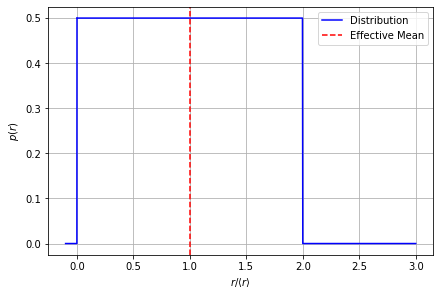

In [6]:
%matplotlib inline

# Either "uniformDist" or "inverseGammaDist"
probabilityDist = uniformDist

# Function for r*p(r)
rpr = lambda r : r*probabilityDist(r)

fig, ax = plt.subplots(constrained_layout=True)

x = np.linspace(0.001,3*mean_distance,1000)
probabilities = np.vectorize(probabilityDist)(x)
ax.plot(x, probabilities, label='Distribution', c='b')
ax.plot([-0.1,0,x[0]], [0,0,probabilities[0]], c='b')
ax.axvline(mean_distance, ls='--', c='r', label='Effective Mean')
ax.grid()
ax.set_xlabel(r"$r/\langle r\rangle$")
ax.set_ylabel(r"$p(r)$")
ax.legend()

plt.show()

## Calculate Carbon Footprint

In [7]:
def delta_av_theory(delta_max, b, mode='mft'):
    delta_max = 1.5
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    if mode=='mft':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
    elif mode=='bimodal_test':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))

    
def cummulative_prob(x):
    return scipy.integrate.quad(probabilityDist,0,x)[0]


def getCarbonIndex(ell, eta, eps0, Q):
    av_d = scipy.integrate.quad(rpr,0,np.infty)[0]
    Ci_drt = 1/eta*(scipy.integrate.quad(rpr,0,zeta*ell)[0] + 2*beta*ell*(1-cummulative_prob(zeta*ell)))/av_d
    Ci_pt = 4*eps0*av_d*Q/ell

    Ci = Ci_drt + Ci_pt

    return Ci, Ci_pt, Ci_drt, av_d


getCarbonIndexVectorized = np.vectorize(getCarbonIndex)


delta_av_theory = delta_av_theory(1.5, 2, mode='mft')

av_drt_occs_non_standing = 2
eta = av_drt_occs_non_standing/delta_av_theory

Ci_theory, Ci_theory_pt, Ci_theory_drt, _= \
    getCarbonIndexVectorized(ell_list, eta, eps0, Q_func(mu))

## Minimise symbolically
### Define Equations

In [8]:
# Non dimensional form
a = 1 / s_beta
b = 2*s_eta*s_eps0*s_Q/(s_beta**2)

cubic_eq = s_ell**3 - a*s_ell**2 + b


# Define depressed cubic (same function, but centered at origin -
# Shift of +a/3)
p = -a**2/3
q = b - 2*a**3/27

depressed_cubic_eq = s_ell**3 + p*s_ell + q

discriminant = (q / 2) ** 2 + (p / 3) ** 3

hessian_11 = 2*(-2*s_beta**2/s_eta + 4*s_eps0*s_Q/s_ell**3)
hessian_22 = s_ell**2/(2*s_eta)
hessian_12_21 = 0

print('Value of discriminant:')
display(
    discriminant.evalf(
        subs={
            s_eps0: eps0,
            s_beta: beta,
            s_eta: av_drt_occs_non_standing/delta_av_theory,
            s_Q: Q
        }
    ),
)

Value of discriminant:


-0.0952899454186834

Discriminant:
$$\frac{Q\varepsilon_0\eta}{\beta^4}\left(Q\varepsilon_0\eta-\frac{2}{27\beta}\right)$$

In [9]:
Critical_Q = 2 / (27*s_eps0*s_eta*s_beta)

print("Critical Q:")
display(Critical_Q)
print("Value:")
Q_crit = Critical_Q.evalf(subs={
            s_eps0: eps0,
            s_beta: beta,
            s_eta: av_drt_occs_non_standing/delta_av_theory,
})
display(Q_crit)

Critical Q:


2/(27*β*ε0*η)

Value:


0.0216210522878036

### Minimise

In [10]:
sol = sympy.solve(depressed_cubic_eq, s_ell)
for i,s in enumerate(sol):
    print(f"Solution {i} for ell/av_r:")
    display(
        (s+a/3).evalf(
            subs={
            s_eps0: eps0,
            s_beta: beta,
            s_eta: av_drt_occs_non_standing/delta_av_theory,
            s_Q: Q
            }
        ),
    )

# ell_min_all_args = sympy.lambdify([s_eps0, s_beta, s_eta, s_Q], sol[0]+a/3)
# print("Test:", ell_min_all_args(eps0, beta, eta, Q))
# ell_min_of_Q = lambda Q: ell_min_all_args(eps0, beta, eta, Q)

# Above method does not work for some reason, so custom:
def ell_min_all_args(solution,eps0,beta,eta,Q):
    sol_tupel = solution.evalf(
            subs={
                s_eps0: eps0,
                s_beta: beta,
                s_eta: eta,
                s_Q: Q
            }
        ).as_real_imag()
    
    result = np.real_if_close(float(sol_tupel[0]) + float(sol_tupel[1])*1j)
#     assert np.isreal(result), "Returning a non real solution"
    return result

ell_min_of_Q = lambda q: ell_min_all_args(sol[0]+a/3,eps0,beta,eta,q)
ell_min_of_Q0_centered = lambda q: ell_min_all_args(sol[0],eps0,beta,eta,q)
ell_min_of_Q1_centered = lambda q: ell_min_all_args(sol[1],eps0,beta,eta,q)
ell_min_of_Q2_centered = lambda q: ell_min_all_args(sol[2],eps0,beta,eta,q)
print("Real part (if imag. part is negligible) of first solution: ", ell_min_of_Q(Q_func(mu)))

Solution 0 for ell/av_r:


0.254611385655763 - 0.e-23*I

Solution 1 for ell/av_r:


2.59092844310197 + 0.e-23*I

Solution 2 for ell/av_r:


-0.231829431577879 + 0.e-20*I

Real part (if imag. part is negligible) of first solution:  0.2546113856557631


In [11]:
display(Markdown(r"Solution for $\zeta$:"))
display(Markdown(r"$\zeta=2\beta$"))
display(Markdown(r"Analytic solution for (non-dimensionalized) $\ell$:"))
display(sympy.simplify((sol[0] + a / 3)))
display(Markdown(r"---"))

Solution for $\zeta$:

$\zeta=2\beta$

Analytic solution for (non-dimensionalized) $\ell$:

(β**2*((27*Q*β*ε0*η + β**3*sqrt(((27*Q*β*ε0*η - 1)**2 - 1)/β**6) - 1)/β**3)**(2/3)*(1 + sqrt(3)*I)**2 + 2*β*((27*Q*β*ε0*η + β**3*sqrt(((27*Q*β*ε0*η - 1)**2 - 1)/β**6) - 1)/β**3)**(1/3)*(1 + sqrt(3)*I) + 4)/(6*β**2*((27*Q*β*ε0*η + β**3*sqrt(((27*Q*β*ε0*η - 1)**2 - 1)/β**6) - 1)/β**3)**(1/3)*(1 + sqrt(3)*I))

---

## Plot carbon footprint

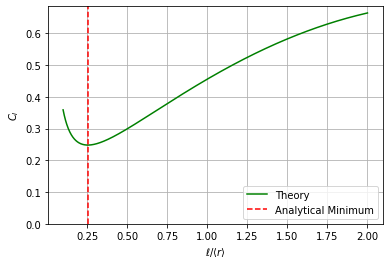

In [13]:
%matplotlib inline
fig, ax = plt.subplots()
xlabel = r"$\ell/\langle r\rangle$"

ax.plot(ell_list, Ci_theory, "-", c='green', label="Theory")
vline = ell_min_of_Q(Q_func(mu))
if np.isreal(vline):
    ax.axvline(vline, ls='--', c='r', label="Analytical Minimum")
ax.set_ylabel(r"$C_I$")

ax.set_xlabel(xlabel)
ax.legend()
ax.grid()

ax.set_ylim((0,None))

plt.show()

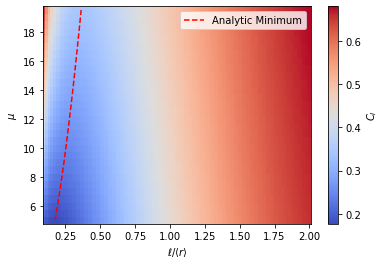

In [14]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots()

mu_range = np.arange(5,20,0.5)
ell_range = np.linspace(ell_min,ell_max,100)
ELL, MU = np.meshgrid(ell_range, mu_range)

CI_THEORY,_,_,_ = getCarbonIndexVectorized(ELL, eta, eps0, Q_func(MU))

# ax.plot_surface(ELL, MU, CI_THEORY, cmap='coolwarm')
im = ax.pcolormesh(ELL, MU, CI_THEORY, cmap='coolwarm', shading='auto')
min_ells = np.vectorize(ell_min_of_Q)(Q_func(mu_range))
min_CIs,_,_,_ = getCarbonIndexVectorized(min_ells, eta, eps0, Q_func(mu_range))
ax.plot(min_ells, mu_range, c='red', ls='--', label='Analytic Minimum')
ax.set_xlabel(r'$\ell/\langle r\rangle$')
ax.set_ylabel(r'$\mu$')
fig.colorbar(im, label=r'$C_I$')

ax.legend()

plt.show()

---
- Carbon emissions for PT are constant w.r.t amount of requests, DRT emissions not on the other hand. Criterion from discriminant shows when DRT emissions $\gtrsim$ PT emissions for high ell?
    - Otherwise Unimodal would be most effective
- For given request frequency - what is a good tradeoff btw. convenience (increasing $\mu$) and emissions (decreasing $\mu$)?
---

## Closer Look at Extrema

In [16]:
%matplotlib inline
deprCubicFunc = sympy.lambdify([s_ell, s_Q, s_eps0, s_eta, s_beta], depressed_cubic_eq)
discrFunc = sympy.lambdify([s_Q, s_eps0, s_eta, s_beta], discriminant)
hessian_11Func = sympy.lambdify([s_ell, s_Q, s_beta, s_eta, s_eps0], hessian_11)
hessian_22Func = sympy.lambdify([s_ell, s_eta], hessian_22)
shift = (a/3).evalf(subs={s_beta: beta})

ells = np.linspace(-2,2,200)
pos_ells = np.linspace(0.1,2+float(shift),100)

def plotDeprCubic(Q):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12.8,4.8))

    ax1.plot(ells+shift, deprCubicFunc(ells, Q, eps0, eta, beta))
    Ci_theory,_,_,_ = \
        getCarbonIndexVectorized(pos_ells, eta, eps0, Q)
    ax2.plot(pos_ells, Ci_theory, "-", c='green', label="Theory")
    ylims = ax1.get_ylim()
    ax1.grid()
    ax2.grid()
    
    ax1.scatter(0, discrFunc(Q, eps0, eta, beta))
    ax1.axhline(0, c='black')
    vline0 = ell_min_of_Q0_centered(Q)
    vline1 = ell_min_of_Q1_centered(Q)
    vline2 = ell_min_of_Q2_centered(Q)
    vline0_shifted = vline0 + shift
    vline1_shifted = vline1 + shift
    vline2_shifted = vline2 + shift
    if np.isreal(vline0):
        ax1.axvline(vline0_shifted, ls='--', c='orange')
        ax1.scatter(vline0_shifted, hessian_11Func(vline0_shifted, Q, beta, eta, eps0), c='orange')
        ax1.scatter(vline0_shifted, hessian_22Func(vline0_shifted, eta), c='orange')
    if np.isreal(vline1):
        ax1.axvline(vline1_shifted, ls='--', c='violet')
        ax1.scatter(vline1_shifted, hessian_11Func(vline1_shifted, Q, beta, eta, eps0), c='violet')
        ax1.scatter(vline1_shifted, hessian_22Func(vline1_shifted, eta), c='violet')
#         display(vline1+shift)
    if np.isreal(vline2):
        ax1.axvline(vline2_shifted, ls='--', c='green')
        ax1.scatter(vline2_shifted, hessian_11Func(vline2_shifted, Q, beta, eta, eps0), c='green')
        ax1.scatter(vline2_shifted, hessian_22Func(vline2_shifted, eta), c='green')
    ax1.set_ylim(ylims)
    if Q < Q_crit:
        fig.suptitle("Q < Q_crit")
    else:
        fig.suptitle("Q > Q_crit")
    plt.show()

# print("To get values of minima all values have to be shifted by +", round(shift,3))
print("Left: The dot is the discriminant, the function is the cubic eq, vlines are zeros of cubic eq, and dots on these lines are eigenvalues of hessian")
print("Right: Carbon Index")
interact(plotDeprCubic, Q=FloatSlider(min=0.001,max=0.04,step=0.001,readout_format='.3f'));

Left: The dot is the discriminant, the function is the cubic eq, vlines are zeros of cubic eq, and dots on these lines are eigenvalues of hessian
Right: Carbon Index


interactive(children=(FloatSlider(value=0.001, description='Q', max=0.04, min=0.001, readout_format='.3f', ste…